In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

import tensorflow.keras as keras

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from keras.preprocessing.image import ImageDataGenerator

In [3]:
#CSV읽어오기

In [4]:
data_input = pd.read_csv('train_data.csv')
data_input.head()


,Unnamed: 0.1,Unnamed: 0,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,...,BIRADS,implant,density,machine_id,difficult_negative_case,x,y,w,h,split
0,0,0,2,5,640805896,L,5,68,0,0,...,0,0,255,21,1,0,357,941,1982,1
1,1,1,2,5,940388076,R,1,68,0,0,...,255,0,255,21,0,1187,50,887,2149,1
2,2,2,2,5,1351088028,L,1,68,0,0,...,0,0,255,21,1,4,334,814,2094,1
3,3,3,2,5,1633417959,R,5,68,0,0,...,255,0,255,21,0,1097,211,985,2157,1
4,4,4,1,25,1789648218,L,1,62,0,0,...,1,0,1,49,0,13,563,1655,3080,0


In [5]:
#img_path로 이미지 경로 추가하기

In [6]:
data_input['img_path'] = data_input.apply(lambda row: f"image/{row.patient_id}_{row.image_id}.png", axis=1)
data_input.head()

,Unnamed: 0.1,Unnamed: 0,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,...,implant,density,machine_id,difficult_negative_case,x,y,w,h,split,img_path
0,0,0,2,5,640805896,L,5,68,0,0,...,0,255,21,1,0,357,941,1982,1,image/5_640805896.png
1,1,1,2,5,940388076,R,1,68,0,0,...,0,255,21,0,1187,50,887,2149,1,image/5_940388076.png
2,2,2,2,5,1351088028,L,1,68,0,0,...,0,255,21,1,4,334,814,2094,1,image/5_1351088028.png
3,3,3,2,5,1633417959,R,5,68,0,0,...,0,255,21,0,1097,211,985,2157,1,image/5_1633417959.png
4,4,4,1,25,1789648218,L,1,62,0,0,...,0,1,49,0,13,563,1655,3080,0,image/25_1789648218.png


In [7]:
DF_train = data_input[data_input['biopsy']==1].reset_index(drop=True)
DF_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2963 entries, 0 to 2962
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0.1             2963 non-null   int64 
 1   Unnamed: 0               2963 non-null   int64 
 2   site_id                  2963 non-null   int64 
 3   patient_id               2963 non-null   int64 
 4   image_id                 2963 non-null   int64 
 5   laterality               2963 non-null   object
 6   view                     2963 non-null   int64 
 7   age                      2963 non-null   int64 
 8   cancer                   2963 non-null   int64 
 9   biopsy                   2963 non-null   int64 
 10  invasive                 2963 non-null   int64 
 11  BIRADS                   2963 non-null   int64 
 12  implant                  2963 non-null   int64 
 13  density                  2963 non-null   int64 
 14  machine_id               2963 non-null  

In [10]:
DF_train = DF_train.groupby(['cancer']).apply(lambda x: x.sample
                                             (1158,replace = True)
                                             ).reset_index(drop=True)

print('New Data Size:', DF_train.shape[0])
print(DF_train.value_counts())

New Data Size: 2316
Unnamed: 0.1  Unnamed: 0  site_id  patient_id  image_id    laterality  view  age  cancer  biopsy  invasive  BIRADS  implant  density  machine_id  difficult_negative_case  x     y    w     h     split  img_path                  
7294          7299        1        8793        699282289   L           5     44   0       1       0         0       0        2        49          1                        1128  169  2198  3091  1      image/8793_699282289.png      12
13851         13856       1        16703       1930741343  L           5     51   1       1       0         0       0        2        49          0                        1371  220  1183  2777  3      image/16703_1930741343.png     9
24158         24163       1        28620       669303826   R           5     55   1       1       1         0       0        2        49          0                        1039  140  1521  2945  1      image/28620_669303826.png      8
3931          3936        2        4824        176

In [18]:
DF_train.loc[120,'img_path']

'image/65530_675828643.png'

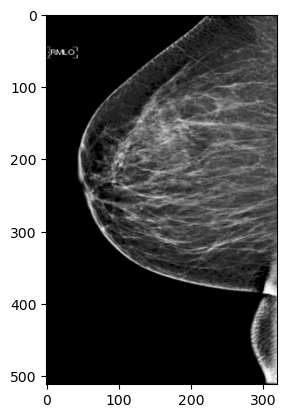

In [19]:
# a sample image
img = cv2.imread(DF_train.loc[120, 'img_path'])
plt.imshow(img, cmap = 'gray')


In [20]:
img.shape

(512, 320, 3)

In [21]:
# 이러면 안된다 학습을 너무 무분별하게 한다 
# 따라서 나는 학습을 L,R로 나누고 view CC(1),MLO(5)를 기준으로 나눠서 학습
#L: [1, 0]
#R: [0, 1]
# CC: [1, 0]
# MLO: [0, 1]
#왼쪽 유방(L)의 크레니오카우달 뷰(CC) 이미지에 대한 벡터는 [1, 0, 1, 0]


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D, concatenate
from keras.optimizers import Adam

laterality_one_hot = pd.get_dummies(DF_train['laterality'], prefix='laterality')
view_one_hot = pd.get_dummies(DF_train['view'], prefix='view')

DF_train_encoded = pd.concat([DF_train, laterality_one_hot, view_one_hot], axis=1)

DF_train_encoded = DF_train_encoded.drop(['laterality', 'view'], axis=1)

#데이터 분할 열
structured_data = DF_train_encoded[['laterality_L', 'laterality_R', 'view_1', 'view_5']].values
target = DF_train_encoded['cancer'].values
image_paths = DF_train_encoded['img_path'].values

#데이터 분할
train_image_paths, test_image_paths, train_structured_data, test_structured_data, train_target, test_target = train_test_split(
    image_paths, structured_data, target, test_size=0.2, random_state=42)

#이미지 로드
def load_and_process_image(image_path):
    # Load image file
    image = load_img(image_path, target_size=(512, 320))  # resize the image to target size while loading
    # Convert the image to numpy array and normalize to [0,1]
    image = img_to_array(image) / 255.0
    return image

train_images = np.array([load_and_process_image(img_path) for img_path in train_image_paths])
test_images = np.array([load_and_process_image(img_path) for img_path in test_image_paths])

# Define the model
image_input = Input(shape=(512, 320, 3))
x = Conv2D(32, (3, 3), activation='relu')(image_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)

structured_input = Input(shape=(4,))
y = Dense(16, activation='relu')(structured_input)
y = Dropout(0.5)(y)

combined = concatenate([x, y])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.5)(z)
z = Dense(32, activation='relu')(z)
z = Dropout(0.5)(z)
output = Dense(1, activation='sigmoid')(z)

model = Model(inputs=[image_input, structured_input], outputs=output)
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

#모델 학습
history = model.fit([train_images, train_structured_data], train_target, validation_split=0.2, epochs=10, batch_size=32)

#test정확도
test_loss, test_acc = model.evaluate([test_images, test_structured_data], test_target)
print("Test accuracy:", test_acc)


Epoch 1/10
47/47 [==============================] - 182s 4s/step - loss: 0.9819 - accuracy: 0.5091 - val_loss: 0.6925 - val_accuracy: 0.5121
Epoch 2/10
47/47 [==============================] - 190s 4s/step - loss: 0.6951 - accuracy: 0.5658 - val_loss: 0.6882 - val_accuracy: 0.5903
Epoch 3/10
47/47 [==============================] - 194s 4s/step - loss: 0.6698 - accuracy: 0.5942 - val_loss: 0.6581 - val_accuracy: 0.6819
Epoch 4/10
47/47 [==============================] - 184s 4s/step - loss: 0.6256 - accuracy: 0.6543 - val_loss: 0.6179 - val_accuracy: 0.7305
Epoch 5/10
47/47 [==============================] - 183s 4s/step - loss: 0.5574 - accuracy: 0.7245 - val_loss: 0.5173 - val_accuracy: 0.7305
Epoch 6/10
47/47 [==============================] - 181s 4s/step - loss: 0.4936 - accuracy: 0.7657 - val_loss: 0.4895 - val_accuracy: 0.7736
Epoch 7/10
47/47 [==============================] - 178s 4s/step - loss: 0.3874 - accuracy: 0.8285 - val_loss: 0.4380 - val_accuracy: 0.8059
Epoch 8/10
47

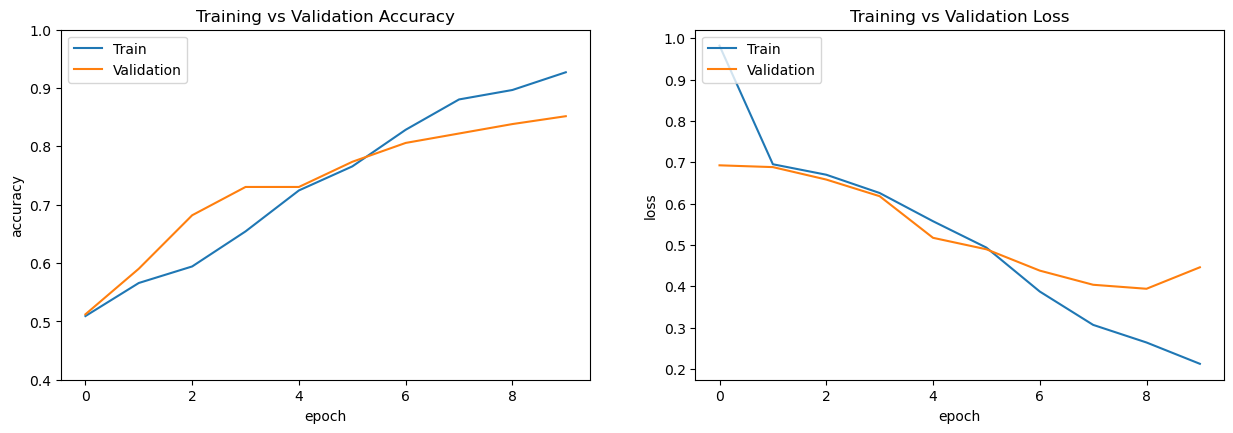

In [17]:
# 학습/검증 정확도 및 손실 값보기
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize = (15,10))

# 훈련/ 검증 정확도
plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.ylim(0.4, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')

# 훈련 /검증 loss
plt.subplot(2, 2, 2)
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()


15/15 [==============================] - 8s 491ms/step


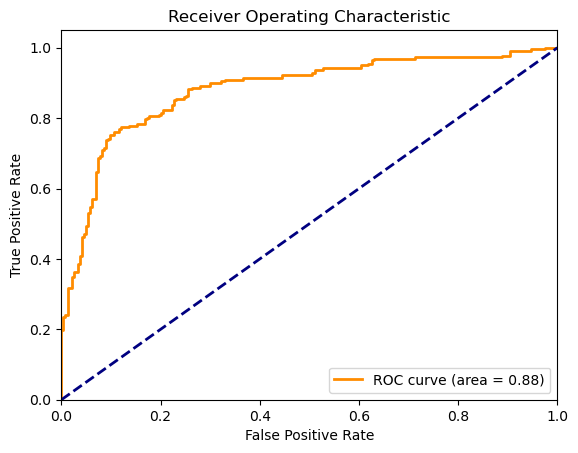

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

test_probabilities = model.predict([test_images, test_structured_data])

#ROC
fpr, tpr, thresholds = roc_curve(test_target, test_probabilities)

roc_auc = auc(fpr, tpr)

# Plot ROC 
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

test_probabilities = model.predict([test_images, test_structured_data])

test_predictions = np.where(test_probabilities > 0.5, 1, 0)

cm = confusion_matrix(test_target, test_predictions)
print("Confusion Matrix:")
print(cm)

cr = classification_report(test_target, test_predictions)
print("Classification Report:")
print(cr)


15/15 [==============================] - 8s 486ms/step
Confusion Matrix:
[[191  52]
 [ 39 182]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       243
           1       0.78      0.82      0.80       221

    accuracy                           0.80       464
   macro avg       0.80      0.80      0.80       464
weighted avg       0.81      0.80      0.80       464



In [16]:
# 모델 예측하기 0.5이상인 값들 은 암으로 그 이하는 암이 아닌걸로
y_pred_prob = model.predict([test_images, test_structured_data])
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_prob]

y_true = test_target

confusion = []
for i, j in zip(y_true, y_pred):
    if i == 0 and j == 0:
        confusion.append('실제로 암이 아니며, 예측도 암이 아님')
    elif i == 1 and j == 1:
        confusion.append('실제로 암이며, 예측도 암')
    elif i == 0 and j == 1:
        confusion.append('실제로 암이 아니지만, 예측은 암')
    else:
        confusion.append('실제로 암이지만, 예측은 암이 아님')

confusion_table = pd.DataFrame({'예측': y_pred,
                                '실제': y_true,
                                '결과': confusion})

confusion_counts = confusion_table['결과'].value_counts()

print(confusion_counts)

15/15 [==============================] - 8s 492ms/step
실제로 암이 아니며, 예측도 암이 아님    191
실제로 암이며, 예측도 암           182
실제로 암이 아니지만, 예측은 암        52
실제로 암이지만, 예측은 암이 아님       39
Name: 결과, dtype: int64
